# Data

## Packages

Import all the packages.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
dat = pd.read_csv('F:\Lab\Majo Data\SKMEL-shape descriptors.csv', header = 0)

In [3]:
data = dat.copy()

## Understand data

After loading the data, the next step is to understand what kind of data it is. It is important to know what each feature is. All the information will help us to preprocess the data before modeling.

Understanding from these parts: the total number of features, the type of features, the correlation among these features, missing value and basic statistics for each features.

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HPI       289 non-null    int64  
 1   Extr      289 non-null    int64  
 2   Region    289 non-null    object 
 3   area      289 non-null    int64  
 4   Perim     289 non-null    float64
 5   Mayor     289 non-null    float64
 6   Minor     289 non-null    float64
 7   Circ      289 non-null    float64
 8   Ar        289 non-null    float64
 9   Round     289 non-null    float64
 10  Solidity  289 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 25.0+ KB


From above:

- Data has one object value, three int values and seven float values.  
- No variable columns has null/missing values.  
- The shape of this data is (289, 11). 

Next step, we will go deep inside these features from different parts.

- **Categorical features** 

>- HPI

In our data, there is a special feature, HPI. This is an ordinal feature. We need to check how many levels it includes. 

In [216]:
levels = data.HPI.unique()
print("the number of levels = " + str(len(levels)))
print("levels = " + str(levels))

the number of levels = 4
levels = [24 72 96 48]


>- Region

Another categorical feature in our data is Region.

In [217]:
regions = data['Region '].unique()
print("the number of regions = " + str(len(regions)))
print("regions = " + str(regions))

the number of regions = 5
regions = ['CV' 'PL' 'AVJ' 'ISV' 'DA']


- **Numerical features** 

Firstly, using df.describe() function to get the basic information about all the numerical features exclude HPI.

In [265]:
numerics = data.drop(['Extr', 'HPI', 'Region '], axis = 1)
numerics.describe()

,area,Perim,Mayor,Minor,Circ,Ar,Round,Solidity
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,5161.757785,530.465426,111.412453,52.034671,0.368934,2.198529,0.598536,0.818540
std,5464.460727,459.618965,83.921854,20.245338,0.265239,1.543613,0.245184,0.121262
min,36.000000,22.971000,7.197000,6.369000,0.028000,1.020000,0.093000,0.336000
25%,1940.000000,232.872000,58.278000,39.014000,0.141000,1.223000,0.397000,0.760000
50%,3501.000000,398.198000,84.804000,51.406000,0.293000,1.576000,0.635000,0.840000
75%,6081.000000,617.176000,131.972000,62.822000,0.564000,2.517000,0.818000,0.914000
max,42170.000000,2799.497000,591.187000,126.034000,0.944000,10.748000,0.981000,0.979000


- These is notably a large difference between 75th %tile and max values of features "area", "Perim", "Mayor", "Minor" and "Ar".

- Thus, from observation 1, it suggests that there might be extreme values outliers in our data set. 

**Correlation**

Then exploring data with graphs. Before building models, it is necessary to check if there is correlated variables. A heatmap in seaborn can visualize the correlation matrix. 

In [219]:
def correlation_heatmap(x):
    corr = x.corr()
    
    fig, ax = plt.subplots(figsize = (8, 8))
    sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot = True, cbar_kws={"shrink": .70})
    plt.show();
    #plt.savefig("F:/Lab/Majo Data/Results/heatmap.jpg")

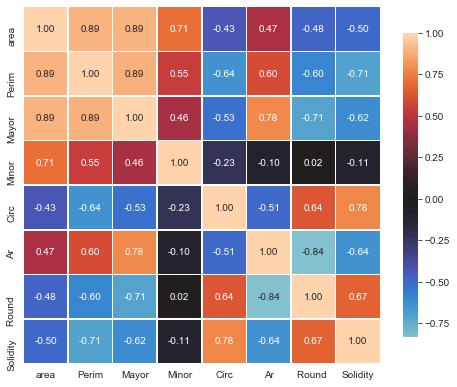

In [220]:
correlation_heatmap(numerics)

From this heatmap with correlation values, we could find some of these features have very strong positive/negative correlation. This will influence a lot for modelling. To solve it, PCA will be a good choice. We would like to apply it later. 

**Outliers**

Next step is to check outliers. Use the boxplot to show.

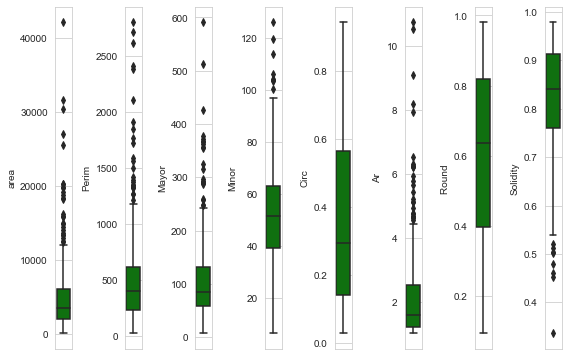

In [221]:
l = numerics.columns.values
number_of_columns=8
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(numerics[l[i]],color='green',orient='v')
    plt.tight_layout()
    

From above box plots for each numerical feature, there exists some outliers for "area", "Perim", "Mayor", "Minor" and "Ar". Consider we could not directly drop off all the outliers, so it is needed to choose multiple models to compare.

**Distributions**

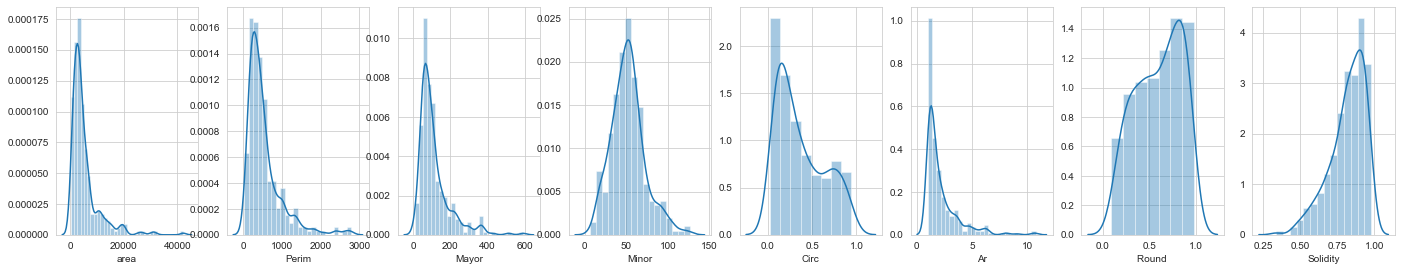

In [222]:
plt.figure(figsize=(3*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(numerics[l[i]],kde=True) 
    
#plt.savefig("F:/Lab/Majo Data/Results/distributions.jpg")

- "Minor" and "Round" is similar to be bell-shaped distribution. And "Minor" looks to be normal distribution.  
- "Area", "Perim", "Mayor", "Circ" and "Ar" are right skewed, "Solidity" is left skewed

**check balance of data**

In [4]:
# split the x part and y part
y = data.Extr
x = data.drop('Extr',axis=1)

In [224]:
sum1 = sum(y == 1)
sum0 = sum(y == 0)
print(sum1)
print(sum0)

142
147


From above result, this data is balanced data.

These two parts are based on the code:
<https://nbviewer.jupyter.org/github/PBPatil/Exploratory_Data_Analysis-Wine_Quality_Dataset/blob/master/winequality_white.ipynb>

Above are some basic analysis for our data. It helps us to understand more details about each feature and what kind of issues we might need to consider when we build models.  
Then we will do the data manipulation before building models.

#  Preprocessing 

Based on the EDA for the our data, we need to do some preprocessing for the data.

## PCA

Some of features have strong positive/negative correlation.One method might help to solve this issue is PCA. Also PCA could be used on numerical features. Remove categorical features: "Region ", "HPI", and then applying PCA on numerical variables part. There are two main application using PCA: dimension reduction and delete strong correlation.

In [5]:
def preprocessingPCA(x, y, test_size = 0.2):
    # split data into training and test sets
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
    
    # seperate the numerical part to apply for PCA 
    x_train_numeric = x_train[['area', 'Perim', 'Mayor', 'Minor', 'Circ', 'Ar', 'Round ', 'Solidity']]
    x_test_numeric = x_test[['area', 'Perim', 'Mayor', 'Minor', 'Circ', 'Ar', 'Round ', 'Solidity']]
    
    x_train_numeric_new = x_train_numeric.reset_index()
    x_train_index = x_train_numeric_new['index']

    x_test_numeric_new = x_test_numeric.reset_index()
    x_test_index = x_test_numeric_new['index']
    
    pca_train = x_train_numeric_new.drop('index', axis = 1)
    pca_test = x_test_numeric_new.drop('index', axis = 1)

    return(x_train_index, x_test_index, pca_train, pca_test, x_train, x_test, y_train, y_test)

In [6]:
x_train_index, x_test_index, prep_train, prep_test, x_train, x_test, y_train, y_test = preprocessingPCA(x, y, test_size = 0.2)

Before directly applying PCA, standardize the data is necessary. Using StandardScaler() function, fit only on train set then transfering on train set and test set.

In [7]:
def myStandardscaler(train, test):
    scaler = StandardScaler()
    scaler.fit(train)
    
    scaler_train = scaler.transform(train)
    scaler_test = scaler.transform(test)
    
    return(scaler_train, scaler_test)

In [8]:
scaler_train, scaler_test = myStandardscaler(prep_train, prep_test)

With scaler_train and scaler_test, fit PCA only on train set and then transfer the new components both on train set and test set. To be noticed, when choosing the number of components, based on 'cumulative explained variance' ability. Find the number of principal components needed to explain 90% of the data variance and compare the performance of the mode fitted to this data.

**PCA with all the components and a plot for cumulative explained variance**

Text(0, 0.5, 'cumulative explained variance')

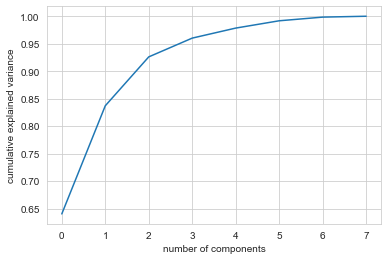

In [271]:
pca_original = PCA().fit(scaler_train)

plt.plot(np.cumsum(pca_original.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#plt.savefig("F:/Lab/Majo Data/Results/PCA_cumulative explained variance.jpg")

From the plot, find the number of principal components needed to reserve is 3.

**PCA with 2 components and a plot just based on 2 components and dependent variables**

In [245]:
pca_twocomponents = PCA(n_components = 2)
pca_components = pca_twocomponents.fit_transform(pca_train)

pcaDf = pd.DataFrame(data = pca_components
             , columns = ['principal component 1', 'principal component 2'], index = x_train_index)

finalDf = pd.concat([pcaDf, y_train], axis = 1)
map_Extr = {0 : 'F', 1 : 'T'}
finalDf['Extr'] = finalDf['Extr'].map(map_Extr)

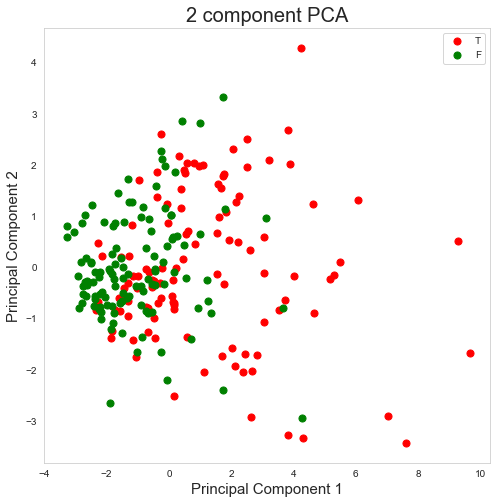

In [247]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['T', 'F']
colors = ['r', 'g']
for Extr, color in zip(targets,colors):
    indicesToKeep = finalDf['Extr'] == Extr
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.savefig("F:/Lab/Majo Data/Results/PCA_2 component.jpg")

**PCA applied on this dataset with 3 components**

In [9]:
def myPCA(scaler_train, scaler_test, x_train_index, x_test_index):
    pca = PCA(0.9).fit(scaler_train)
    feature_weights = pca.components_
    
    pca_train = pd.DataFrame(pca.transform(scaler_train), index = x_train_index)
    pca_test = pd.DataFrame(pca.transform(scaler_test), index = x_test_index)
    
    return(pca_train, pca_test, feature_weights)

In [10]:
pca_train, pca_test, feature_weights = myPCA(scaler_train, scaler_test, x_train_index, x_test_index)

<Figure size 144x144 with 0 Axes>

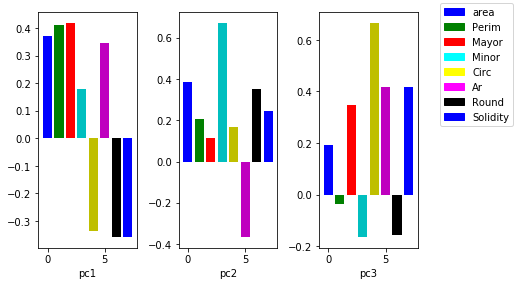

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(2,2))

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.bar(range(8),feature_weights[0],color=['b','g','r','c','y','m','k','b'])
ax2.bar(range(8),feature_weights[1],color=['b','g','r','c','y','m','k','b'])
ax3.bar(range(8),feature_weights[2],color=['b','g','r','c','y','m','k','b'])

ax1.set_xlabel('pc1')
ax2.set_xlabel('pc2')
ax3.set_xlabel('pc3')

colors = {'area':'blue', 'Perim':'green', 'Mayor':'red', 'Minor':'cyan', 'Circ':'yellow', 'Ar':'magenta', 'Round':'black', 'Solidity':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
fig.legend(handles, labels, bbox_to_anchor=(1.2, 1))


fig.tight_layout()

#fig.savefig("F:/Lab/Majo Data/Results/feature_weights.jpg", bbox_inches='tight')

In [12]:
def combineDf(pca_train, pca_test, x_train, x_test):
    pca_train.columns = ['pc1', 'pc2', 'pc3']
    pca_test.columns = ['pc1', 'pc2', 'pc3']
    
    x_train_new = pd.concat([pca_train, x_train[['HPI']], x_train[['Region ']]], axis = 1)
    x_test_new = pd.concat([pca_test, x_test[['HPI']], x_test[['Region ']]], axis = 1)
    
    return(x_train_new, x_test_new)

In [13]:
x_train_new, x_test_new = combineDf(pca_train, pca_test, x_train, x_test)

## Encode

Here, we use encoding method for categorical features. 
"HPI" is ordinal feature, so we use ordinal encoding for "HPI", there are four levels, instead using the original data, we use level 1, 2, 3, 4 to show different "HPI"
"Region " is nominal feature, and the Region number > 4, consider using target encoding. 

In [14]:
def ord_encode(X):
    x = X.copy()
    map1 = {24 : 0, 48 : 1, 72 : 2, 96: 3}
    x['HPI'] = x['HPI'].map(map1)
    return x

In [15]:
x_train_new = ord_encode(x_train_new)
x_test_new = ord_encode(x_test_new)

In [16]:
enc = TargetEncoder(cols=['Region ']).fit(x_train_new, y_train)

x_train_new = enc.transform(x_train_new)
x_test_new = enc.transform(x_test_new)

# Models

After doing data manipulation, the next step is trying different models on the data to see the prediction performance.

## Logistic Regression  
Since this is a binary classification problem. The first model to try is logistic regression.

In [25]:
x_train_new02 = x_train_new.drop(['pc2','pc3','Region '], axis = 1)
x_test_new02 = x_test_new.drop(['pc2', 'pc3', 'Region '], axis = 1)

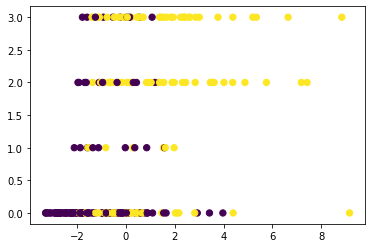

In [51]:
# Generate a dataset and plot it
plt.scatter(x_train_new02['pc1'].values, x_train_new02['HPI'].values, s=40, c=y_train)
plt.savefig("F:/Lab/Majo Data/Results/scatterforExtr.jpg")

In [43]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(x_train_new02, y_train);
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.

def plot_decision_boundary(pred_func, X, y):

    # Set min and max values and give it some padding
    x_min, x_max = X['pc1'].values.min() - .5, X['pc1'].values.max() + .5
    y_min, y_max = X['HPI'].values.min() - .5, X['HPI'].values.max() + .5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X['pc1'].values, X['HPI'].values, c=y, cmap=plt.cm.Spectral)

Reference for above function

<https://stackoverflow.com/questions/34829807/understand-how-this-lambda-function-works>

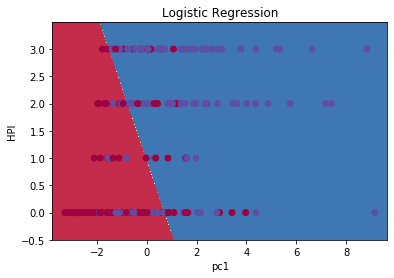

In [50]:
plot_decision_boundary(lambda x_train_new02: clf.predict(x_train_new02), x_train_new02, y_train)
plt.title("Logistic Regression")
plt.xlabel('pc1')
plt.ylabel('HPI')

plt.savefig("F:/Lab/Majo Data/Results/LogisticRegression_2features.jpg")

In [49]:
# Print accuracy
LR_predictions = clf.predict(x_test_new02)
y_pred_train = clf.predict(x_train_new02)
accuracy_score_train = clf.score(x_train_new02, y_train)
accuracy_score = clf.score(x_test_new02, y_test)
print(accuracy_score_train)
print(accuracy_score)

0.7575757575757576
0.7413793103448276


In [282]:
def LRmodel(x_train_new, x_test_new, y_train, y_test):
    lr = LogisticRegression()
    lr.fit(x_train_new, y_train)
    scores = cross_val_score(lr, x_train_new, y_train, cv = 10)
    scores = pd.Series(scores)
    scores = scores.mean()
    
    y_pred_train = lr.predict(x_train_new)
    p_train = np.mean(y_pred_train == y_train)  #or lr.score(x_train_new, y_train)
    
    y_pred_test = lr.predict(x_test_new)
    y_pred_test_prob = lr.predict_proba(x_test_new)
    p_test = np.mean(y_pred_test == y_test)     #or lr.score(x_test_new, y_test)
    
    d = {"accuracy of train set": p_train,
         "accuracy of test set": p_test,
         "y_pred_train": y_pred_train, 
         "y_pred_test" : y_pred_test,
         "y_pred_test_prob" : y_pred_test_prob[:,1],
         "Cross Validation Accuracy Scores": scores}
    
    return lr, d

In [284]:
lr, d = LRmodel(x_train_new, x_test_new, y_train, y_test)
print(d)

{'accuracy of train set': 0.7575757575757576, 'accuracy of test set': 0.7241379310344828, 'y_pred_train': array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int64), 'y_pred_test': array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0,

In [283]:
lr_update, d_update = LRmodel(x_train_new02, x_test_new02, y_train, y_test)
print(d_update)

{'accuracy of train set': 0.7662337662337663, 'accuracy of test set': 0.6896551724137931, 'y_pred_train': array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int64), 'y_pred_test': array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0,

In [285]:
submission = pd.DataFrame({'id':x_test_index, 'pred_Extr':d['y_pred_test'], 'pred_Extr_prob':d["y_pred_test_prob"]})
submission.to_csv('F:/Lab/Majo Data/Results/prediction_LRmodel(2components).csv')

Above shows the prediction performance on out test set is about 72%. But at the train_test_split part, there is a random process. So using cross validation on train set, obtaining a mean prediction score is about 76% accuracy. 

In [286]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    
    dd = {"lr coefs": coefs,
         "lr p_value": p}
    
    return dd

In [242]:
dd = logit_pvalue(lr, x_train_new)
print(dd)

{'lr coefs': array([-1.23217933,  0.52939203, -0.06934893,  0.14817832,  0.64946832,
        1.2696131 ]), 'lr p_value': array([4.11153800e-02, 4.38461499e-06, 6.31229287e-01, 5.24630699e-01,
       2.16309125e-05, 2.85157857e-01])}


In [287]:
dd_update = logit_pvalue(lr_update, x_train_new02)
print(dd_update)

{'lr coefs': array([-0.44149195,  0.72552287,  0.53740222]), 'lr p_value': array([6.14410515e-02, 1.78761519e-08, 3.47665328e-04])}


In [288]:
c_p = pd.DataFrame({'coefs': dd['lr coefs'], 'p_value':dd['lr p_value']})
c_p.to_csv('F:/Lab/Majo Data/Results/c_p_LRmodel_(2 components).csv')

## Random Forest

In [243]:
def rfmodel(x_train_new, x_test_new, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True)
    # Fit on training data
    model.fit(x_train_new, y_train)
    rf_pred_train = model.predict(x_train_new)
    rf_p_train = model.score(x_train_new, y_train)


    # Actual class predictions
    rf_pred_test = model.predict(x_test_new)
    rf_p_test = model.score(x_test_new, y_test)


    # Probabilities for each class
    rf_probs = model.predict_proba(x_test_new)[:, 1]
    
    ddd = {"rf accuracy on train set": rf_p_train,
         "rf accuracy on test set": rf_p_test}
    
    return ddd

In [244]:
rfmodel(x_train_new, x_test_new, y_train, y_test)

{'rf accuracy on train set': 1.0,
 'rf accuracy on test set': 0.8448275862068966}

# Conclusion

Apply logistic regression and random forest on the data set.

**Logistic Regression:**
>- The accuracy of prediction is about 74% on cross_validation set and is about 70% on test set.

>- From the p_value for "principal component 1", "principal component 2", "principal component 3", "HPI", "Region ", find "principal component 1", "HPI" has extreme small p value, so it means these features are significant related to whether Extravasation or not.

**Random forest:**
>- Try random forest because in the data there are some outliers in some features. Instead of removing these outliers, consider to use random forest model to decrease the potential influence.

>- The accuracy of prediction is about 100% on train set and is about 70% on test set. Since we mainly want the high accuracy on test set, seems random forest model has similar result with logistic regression (notice: since there is random part, sometimes the random forest has better prediction result on the data)

**Future work**

Now we already tried logistic regression and random forest, both of them have a good accuracy on prediction performance, but not very high accuracy. Logistic regression could show a clear model with which part is significant related to the dependent variable(extravasation). From this part, logistic regression is a good choice. 
The next step for analyzing data part is that we could try more models on our data and also to tune hyperparameters for the logistic regression model which might improve the accuracy of prediction.